Plot heat call frequency as a function of SWT and heat load, for one house or for one zone

# Isolate heat calls

## Query data

In [1]:
import dotenv
import numpy as np
import pandas as pd
import pendulum
from sqlalchemy import asc, cast
from sqlalchemy import create_engine, select, BigInteger
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, select, BigInteger
from config import Settings
from models import MessageSql

house_alias = "beech"
timezone_str = "America/New_York"
start_ms = pendulum.datetime(2025, 11, 23, 0, tz=timezone_str).timestamp()*1000
end_ms = pendulum.datetime(2025, 11, 23, 13, tz=timezone_str).timestamp()*1000

stmt = select(MessageSql).filter(
    MessageSql.message_type_name == "report",
    MessageSql.from_alias == f"hw1.isone.me.versant.keene.{house_alias}.scada",
    MessageSql.message_persisted_ms <= cast(int(end_ms), BigInteger),
    MessageSql.message_persisted_ms >= cast(int(start_ms), BigInteger),
).order_by(asc(MessageSql.message_persisted_ms))

settings = Settings(_env_file=dotenv.find_dotenv())
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)
session = Session()
result = session.execute(stmt)
messages = result.scalars().all()

## Clean data

In [2]:
# Sort data by channels
channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        if message.message_type_name == 'report':
            channel_name = channel['ChannelName']
        elif message.message_type_name == 'batched.readings':
            for dc in message.payload['DataChannelList']:
                if dc['Id'] == channel['ChannelId']:
                    channel_name = dc['Name']
        if channel_name not in channels:
            channels[channel_name] = {'times': [], 'values': []}
        channels[channel_name]['times'].extend(channel['ScadaReadTimeUnixMsList'])
        channels[channel_name]['values'].extend(channel['ValueList'])
    
if not channels:
    print(f"No channels found in messages")
    exit()

for channel in channels.keys():
    sorted_times_values = sorted(zip(channels[channel]['times'], channels[channel]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[channel]['values'] = list(sorted_values)
    channels[channel]['times'] = list(sorted_times)

# Get synchronous data for required data channels
required_channels = ['dist-swt', 'dist-rwt', 'dist-flow'] + [x for x in channels if 'zone' in x and 'whitewire' in x]

timestep_seconds = 30
num_points = int((end_ms - start_ms) / (timestep_seconds * 1000) + 1)

csv_times = np.linspace(start_ms, end_ms, num_points)
csv_times_dt = pd.to_datetime(csv_times, unit='ms', utc=True)
csv_times_dt = [x.tz_convert(timezone_str).replace(tzinfo=None) for x in csv_times_dt]

csv_values = {'times': csv_times}
for channel in required_channels:
    if channel not in channels or not channels[channel]['times']:
        continue
    channels[channel]['times'] = pd.to_datetime(channels[channel]['times'], unit='ms', utc=True)
    channels[channel]['times'] = [x.tz_convert(timezone_str) for x in channels[channel]['times']]
    channels[channel]['times'] = [x.replace(tzinfo=None) for x in channels[channel]['times']]
    
    try:
        merged = pd.merge_asof(
            pd.DataFrame({'times': csv_times_dt}),
            pd.DataFrame(channels[channel]).ffill(),
            on='times',
            direction='backward'
        )
        csv_values[channel] = list(merged['values'])

    except Exception as e:
        print(f"Error merging data around {csv_times_dt[0]} : {e}")
        merged = pd.merge_asof(
            pd.DataFrame({'times': csv_times_dt}).sort_values('times'),
            pd.DataFrame(channels[channel]).sort_values('times'),
            on='times',
            direction='backward'
        )
        csv_values[channel] = list(merged['values'])

# Calculations from synchronous data
df = pd.DataFrame(csv_values)

# Zones
whitewire_threshold_watts = {'beech': 100, 'elm': 0.9, 'default': 20}
if house_alias in whitewire_threshold_watts:
    whitewire_threshold = whitewire_threshold_watts[house_alias]
whitewire_channels = [c for c in csv_values if 'whitewire' in c]
if [c for c in whitewire_channels if 'zone1' in c]:
    zone1_ch = [c for c in whitewire_channels if 'zone1' in c][0]
    df[zone1_ch] = [int(abs(x)>whitewire_threshold) for x in df[zone1_ch]]
    df['zone1_cumulative'] = df[zone1_ch].cumsum()
    zone1_heatcall_fraction = round(list(df['zone1_cumulative'])[-1] / len(df['zone1_cumulative']), 2)
if [c for c in whitewire_channels if 'zone2' in c]:
    zone2_ch = [c for c in whitewire_channels if 'zone2' in c][0]
    df[zone2_ch] = [int(abs(x)>whitewire_threshold) for x in df[zone2_ch]]
    df['zone2_cumulative'] = df[zone2_ch].cumsum()
    zone2_heatcall_fraction = round(list(df['zone2_cumulative'])[-1] / len(df['zone2_cumulative']), 2)
if [c for c in whitewire_channels if 'zone3' in c]:
    zone3_ch = [c for c in whitewire_channels if 'zone3' in c][0]
    df[zone3_ch] = [int(abs(x)>whitewire_threshold) for x in df[zone3_ch]]
    df['zone3_cumulative'] = df[zone3_ch].cumsum()
    zone3_heatcall_fraction = round(list(df['zone3_cumulative'])[-1] / len(df['zone3_cumulative']), 2)
if [c for c in whitewire_channels if 'zone4' in c]:
    zone4_ch = [c for c in whitewire_channels if 'zone4' in c][0]
    df[zone4_ch] = [int(abs(x)>whitewire_threshold) for x in df[zone4_ch]]
    df['zone4_cumulative'] = df[zone4_ch].cumsum()
    zone4_heatcall_fraction = round(list(df['zone4_cumulative'])[-1] / len(df['zone4_cumulative']), 2)

def to_fahrenheit(x):
    return x * 9/5 + 32

df['timestamp'] = df['times']
df['times'] = pd.to_datetime(df['times'], unit='ms')
df['dist-flow'] = df['dist-flow'] / 100
df['dist-swt'] = to_fahrenheit(df['dist-swt'] / 1000)
df['dist-rwt'] = to_fahrenheit(df['dist-rwt'] / 1000)
df

,times,dist-swt,dist-rwt,dist-flow,zone1-down-whitewire-pwr,zone2-up-whitewire-pwr,zone1_cumulative,zone2_cumulative,timestamp
0,2025-11-23 05:00:00,115.538,101.588,0.0,1,0,1,0,1.763874e+12
1,2025-11-23 05:00:30,115.178,101.588,0.0,1,0,2,0,1.763874e+12
2,2025-11-23 05:01:00,127.058,100.634,2.0,1,0,3,0,1.763874e+12
3,2025-11-23 05:01:30,134.348,94.622,2.0,1,0,4,0,1.763874e+12
4,2025-11-23 05:02:00,136.436,94.208,2.0,1,0,5,0,1.763874e+12
...,...,...,...,...,...,...,...,...,...
1556,2025-11-23 17:58:00,99.950,86.846,0.0,0,0,400,21,1.763921e+12
1557,2025-11-23 17:58:30,99.950,86.846,0.0,0,0,400,21,1.763921e+12
1558,2025-11-23 17:59:00,99.950,86.846,0.0,0,0,400,21,1.763921e+12
1559,2025-11-23 17:59:30,99.950,86.846,0.0,0,0,400,21,1.763921e+12



Heat call 0
Average load: None kW
Average SWT: 137 F
Heat call length: 270 seconds
Time before next heat call: 960

Heat call 1
Average load: None kW
Average SWT: 137 F
Heat call length: 210 seconds
Time before next heat call: 1050

Heat call 2
Average load: None kW
Average SWT: 137 F
Heat call length: 270 seconds
Time before next heat call: 1080

Heat call 3
Discarded.

Heat call 4
Average load: None kW
Average SWT: 135 F
Heat call length: 240 seconds
Time before next heat call: 1050

Heat call 5
Average load: None kW
Average SWT: 133 F
Heat call length: 300 seconds
Time before next heat call: 900

Heat call 6
Average load: None kW
Average SWT: 135 F
Heat call length: 270 seconds
Time before next heat call: 1020

Heat call 7
Average load: None kW
Average SWT: 134 F
Heat call length: 330 seconds
Time before next heat call: 840

Heat call 8
Average load: None kW
Average SWT: 132 F
Heat call length: 330 seconds
Time before next heat call: 960

Heat call 9
Average load: None kW
Average S

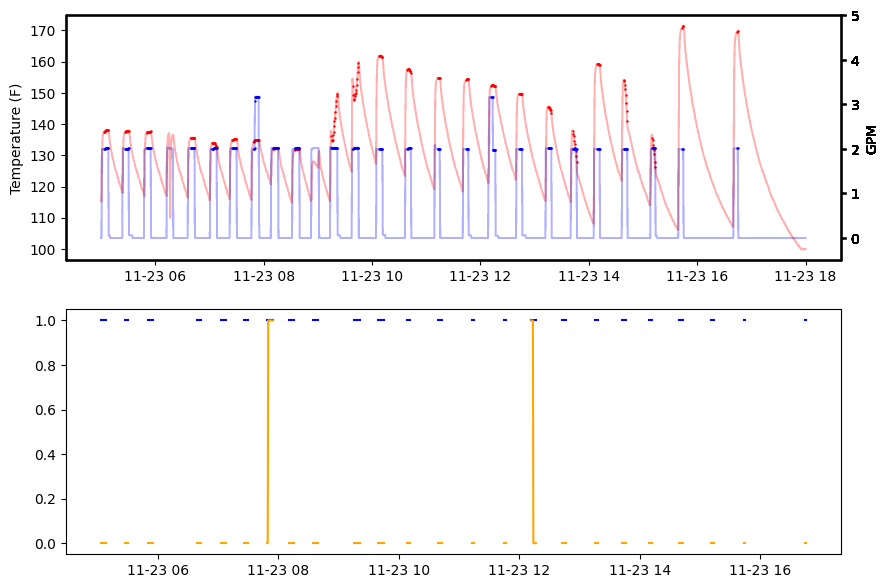

In [3]:
from curses import noqiflush
import matplotlib.pyplot as plt

split_segments = []
in_segment = False
segment_start = None

for idx, row in df.iterrows():
    flow = row['dist-flow']
    # Heat call starts
    if not in_segment and flow > 1.8:
        in_segment = True
        segment_start = idx
    # Heat call ends
    elif in_segment and flow < 1:
        segment_end = idx
        split_segments.append((segment_start, segment_end))
        in_segment = False
        segment_start = None

# If segment carried to end of df
if in_segment and segment_start is not None:
    split_segments.append((segment_start, df.index[-1]))

# Create a new df for just these ranges
split_dfs = []
for start_idx, end_idx in split_segments:
    if end_idx < df.index[-1]:
        segment_df = df.loc[start_idx:end_idx]
    else:
        segment_df = df.loc[start_idx:]
    segment_df = segment_df[:-1]
    split_dfs.append(segment_df)

fig, ax = plt.subplots(2,1, figsize=(10, 7))
for x, split_df in enumerate(split_dfs):
    split_df.reset_index(drop=True, inplace=True)
    for i in range(len(split_df)-1):
        if (
            (split_df.iloc[i+1]['dist-swt']-split_df.iloc[i]['dist-swt']) / (split_df.iloc[i+1]['timestamp']-split_df.iloc[i]['timestamp']) * 1000
            ) < 0.001:
            split_df = split_df.iloc[i+1:]
            break
    for i in range(len(split_df)-1):
        if (
            (split_df.iloc[i+1]['dist-swt']-split_df.iloc[i]['dist-swt']) / (split_df.iloc[i+1]['timestamp']-split_df.iloc[i]['timestamp']) * 1000
            ) > 0.1:
            split_df = split_df[split_df['dist-swt'] > 1e9]
            break

    print(f"\nHeat call {x}")
    if not split_df.empty:
        avg_load = None
        avg_swt = int(sum(split_df['dist-swt'])/len(split_df))
        heat_call_duration_s = int((max(split_df['timestamp'])-min(split_df['timestamp']))/1000)
        if len(split_dfs) > x+1:
            next_split_df = split_dfs[x+1]
            time_before_next_heat_call_s = int((min(next_split_df['timestamp'])-max(split_df['timestamp']))/1000)
        else:
            time_before_next_heat_call_s = None
        print(f"Average load: {avg_load} kW")
        print(f"Average SWT: {avg_swt} F")
        print(f"Heat call length: {heat_call_duration_s} seconds")
        print(f"Time before next heat call: {time_before_next_heat_call_s}")
    else:
        print("Discarded.")

    ax2 = ax[0].twinx()
    ax[0].plot(df['times'], df['dist-swt'], color='red', alpha=0.01)
    ax[0].scatter(split_df['times'], split_df['dist-swt'], color='red', s=0.5)
    ax[0].set_ylabel('Temperature (F)')
    ax2.plot(df['times'], df['dist-flow'], color='blue', alpha=0.01)
    ax2.scatter(split_df['times'], split_df['dist-flow'], color='blue', s=0.5)
    ax2.set_ylabel('GPM')
    ax2.set_ylim(-0.5, 5)

    ax[1].plot(split_df['times'], split_df['zone1-down-whitewire-pwr'], color='blue')
    ax[1].plot(split_df['times'], split_df['zone2-up-whitewire-pwr'], color='orange')
plt.show()